# Human Data Analytics course project
## predict lung disease from X-ray images

Since we implemented the project on Colab, we uploaded the data one our drive and mounted in colab.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Importing Libraries such as tensorflow

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.applications import DenseNet121,MobileNetV2,vgg19
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom, Rescaling
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2, DenseNet121
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#### Check available data

In [ ]:
root_train = '/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/train/'
root_test = '/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/'

labels = ['normal', 'pneumonia','covid']

def check_ims_in_folder(labels):
    #returns tuples of images in each folder
    train_ims_normal = os.listdir(root_train+labels[0]+'/')
    train_ims_pneumonia = os.listdir(root_train+labels[1]+'/')
    train_ims_covid = os.listdir(root_train+labels[2]+'/')
    
    
    test_ims_normal = os.listdir(root_test+labels[0]+'/')
    test_ims_pneumonia = os.listdir(root_test+labels[1]+'/')
    test_ims_covid = os.listdir(root_test+labels[2]+'/')
    
    return (train_ims_normal, train_ims_pneumonia,train_ims_covid), (test_ims_normal, test_ims_pneumonia,test_ims_covid)

#####Let's see the number of images in Train and Test folders for each labe

[0.15 1.15 2.15 3.15 4.15 5.15]


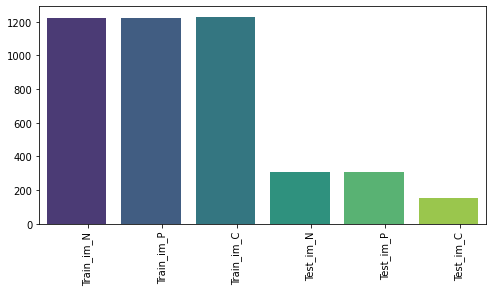

train_im_N:  1220
train_im_P:  1220
train_im_C:  1230
test_im_N:  305
test_im_P:  305
test_im_C:  151


In [ ]:
(train_im_n, train_im_p, train_im_c), (test_im_n, test_im_p, test_im_c) = check_ims_in_folder(labels)


index = np.arange(6) + 0.15
print (index)
labels_bar = ['Train_im_N', 'Train_im_P', 'Train_im_C', 'Test_im_N', 'Test_im_P','Test_im_C']

fig=plt.figure(figsize=(8, 4))
sns.barplot(x=index, y=[len(train_im_n), len(train_im_p), len(train_im_c), len(test_im_n), len(test_im_p),len(test_im_c)], palette="viridis")
plt.xticks(index, labels_bar, rotation='vertical')
plt.show()

print ('train_im_N: ', len(train_im_n))
print ('train_im_P: ', len(train_im_p))
print ('train_im_C: ', len(train_im_c))
print ('test_im_N: ', len(test_im_n))
print ('test_im_P: ', len(test_im_p))
print ('test_im_C: ', len(test_im_c))

#####Total number of each labels images

In [ ]:
tot_normal_train = len(train_im_n) + len(test_im_n) 
tot_pneumonia_train = len(train_im_p) + len(test_im_p)
tot_covid_train = len(train_im_c) + len(test_im_c) 
print ('total normal xray images: ', tot_normal_train)
print ('total pneumonia xray images: ', tot_pneumonia_train)
print ('total covid xray images: ', tot_covid_train)

total normal xray images:  1525
total pneumonia xray images:  1525
total covid xray images:  1381


####Check Image Size Disrtibution (Each Folder)

In [ ]:
def check_im_size(folder, labels):
    im_shape_x_lists_n = []
    im_shape_x_lists_p = []
    im_shape_x_lists_c = []
    im_shape_y_lists_n = []
    im_shape_y_lists_p = []
    im_shape_y_lists_c = []

    if folder=='train':
        path = root_train
        normal = train_im_n
        pneumonia = train_im_p
        covid = train_im_c
    else:
        path = root_test
        normal = test_im_n
        pneumonia = test_im_p
        covid = test_im_c
    for i, img in enumerate(normal):
        sample = os.path.join(path+labels[0]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_n.append(w)
        im_shape_y_lists_n.append(h)
    for i, img in enumerate(pneumonia):
        sample = os.path.join(path+labels[1]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_p.append(w)
        im_shape_y_lists_p.append(h)
    for i, img in enumerate(covid):
        sample = os.path.join(path+labels[2]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_c.append(w)
        im_shape_y_lists_c.append(h)
        
    return im_shape_x_lists_n, im_shape_y_lists_n, im_shape_x_lists_p, im_shape_y_lists_p,im_shape_x_lists_c,im_shape_y_lists_c

In [ ]:
im_shape_train_x_n, im_shape_train_y_n, im_shape_train_x_p, im_shape_train_y_p,im_shape_train_x_c,im_shape_train_y_c = check_im_size('train', labels)
im_shape_test_x_n, im_shape_test_y_n, im_shape_test_x_p, im_shape_test_y_p,im_shape_test_x_c, im_shape_test_y_c= check_im_size('test', labels)  

The sizes of the images vary over a wide range. So best option is to fix a size for all. Since we are using InceptionResNet, the input size we will consider is 300x300.

{1024} {1024}


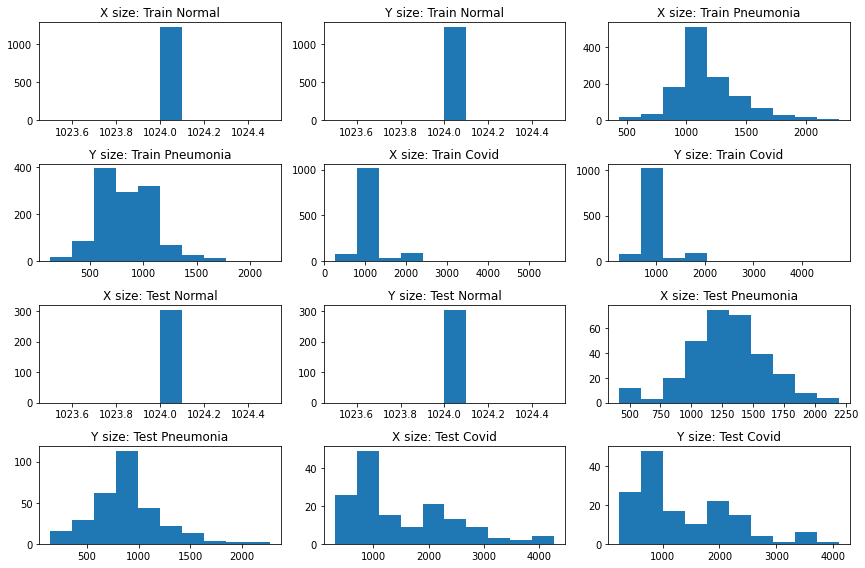

In [ ]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(431)
plt.hist(im_shape_train_x_n)
plt.title('X size: Train Normal')
fig.add_subplot(432)
plt.hist(im_shape_train_y_n)
plt.title('Y size: Train Normal')
fig.add_subplot(433)
plt.hist(im_shape_train_x_p)
plt.title('X size: Train Pneumonia')
fig.add_subplot(434)
plt.hist(im_shape_train_y_p)
plt.title('Y size: Train Pneumonia')
fig.add_subplot(435)
plt.hist(im_shape_train_x_c)
plt.title('X size: Train Covid')
fig.add_subplot(436)
plt.hist(im_shape_train_y_c)
plt.title('Y size: Train Covid')
fig.add_subplot(437)
plt.hist(im_shape_test_x_n)
plt.title('X size: Test Normal')
fig.add_subplot(438)
plt.hist(im_shape_test_y_n)
plt.title('Y size: Test Normal')
fig.add_subplot(439)
plt.hist(im_shape_test_x_p)
plt.title('X size: Test Pneumonia')
fig.add_subplot(4,3, 10)
plt.hist(im_shape_test_y_p)
plt.title('Y size: Test Pneumonia')
fig.add_subplot(4,3, 11)
plt.hist(im_shape_test_x_c)
plt.title('X size: Test Covid')
fig.add_subplot(4,3, 12)
plt.hist(im_shape_test_y_c)
plt.title('Y size: Test Covid')
plt.tight_layout()
print (set(im_shape_train_x_n), set(im_shape_train_y_n))

#####Check and visualize some images

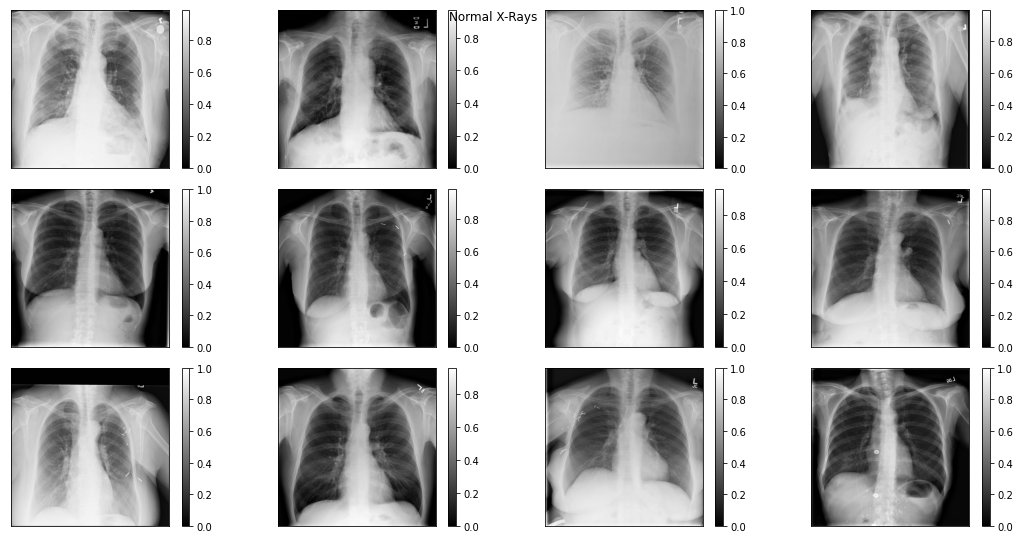

check shape of an example image:  (1024, 1024)


In [ ]:
import os, time, random
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_n_selected = random.sample(train_im_n, 12)
for i, img in enumerate(train_im_n_selected):
    sample = os.path.join(root_train +labels[0]+'/', img) 
    sample_img = Image.open(sample)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    ax = fig.add_subplot(int(npics/3) , 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    plt.colorbar()
    count +=1
fig.suptitle('Normal X-Rays')
plt.tight_layout()
plt.show()

print ('check shape of an example image: ', sample_img.shape,)

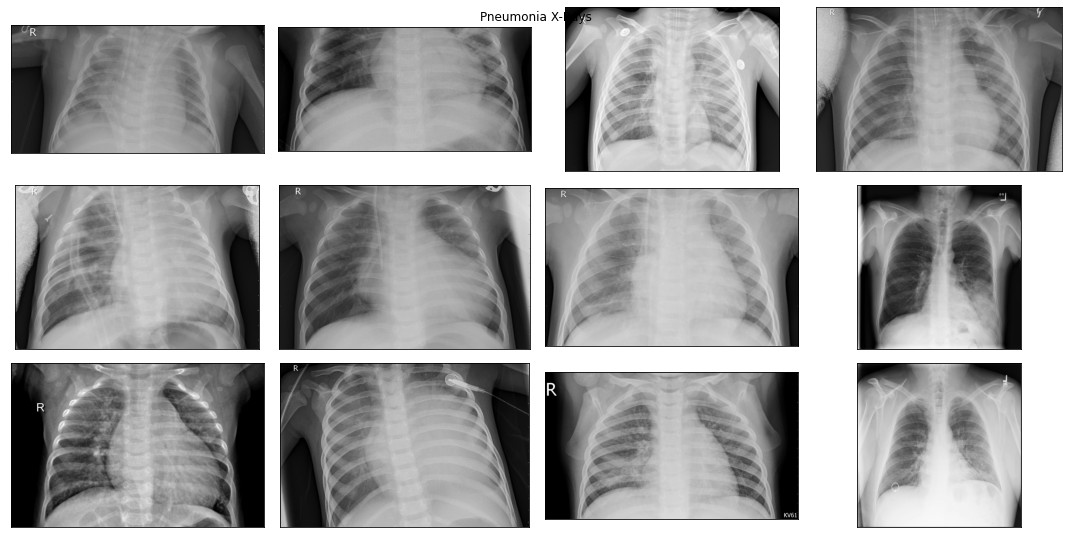

In [ ]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_p_selected = random.sample(train_im_p, 12)
for i, img in enumerate(train_im_p_selected):
    sample = os.path.join(root_train +labels[1]+'/', img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(int(npics/3), 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    count +=1
fig.suptitle('Pneumonia X-Rays')
plt.tight_layout()
plt.show()

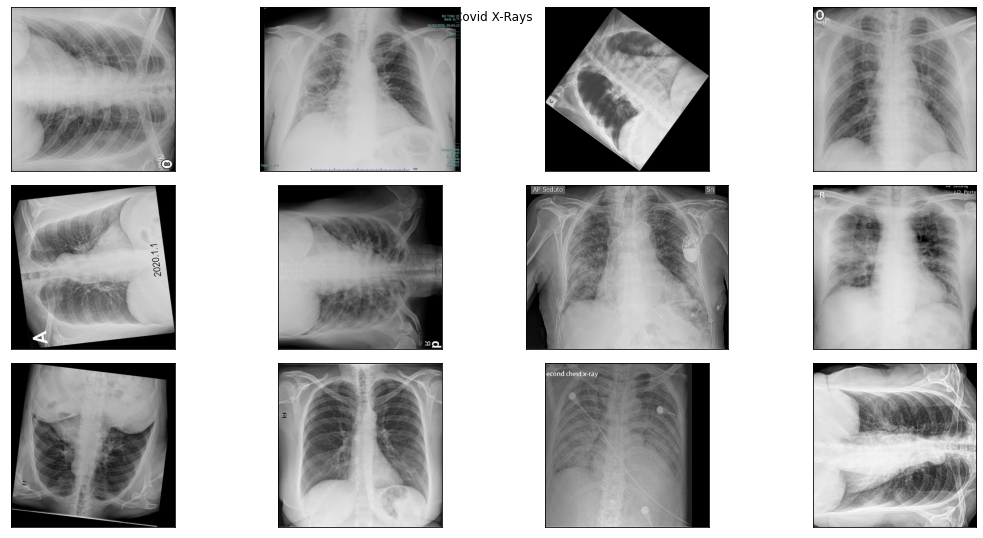

In [ ]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_c_selected = random.sample(train_im_c, 12)
for i, img in enumerate(train_im_c_selected):
    sample = os.path.join(root_train +labels[2]+'/', img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(int(npics/3), 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    count +=1
fig.suptitle('Covid X-Rays')
plt.tight_layout()
plt.show()

####Standardization
We will adjust our image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.

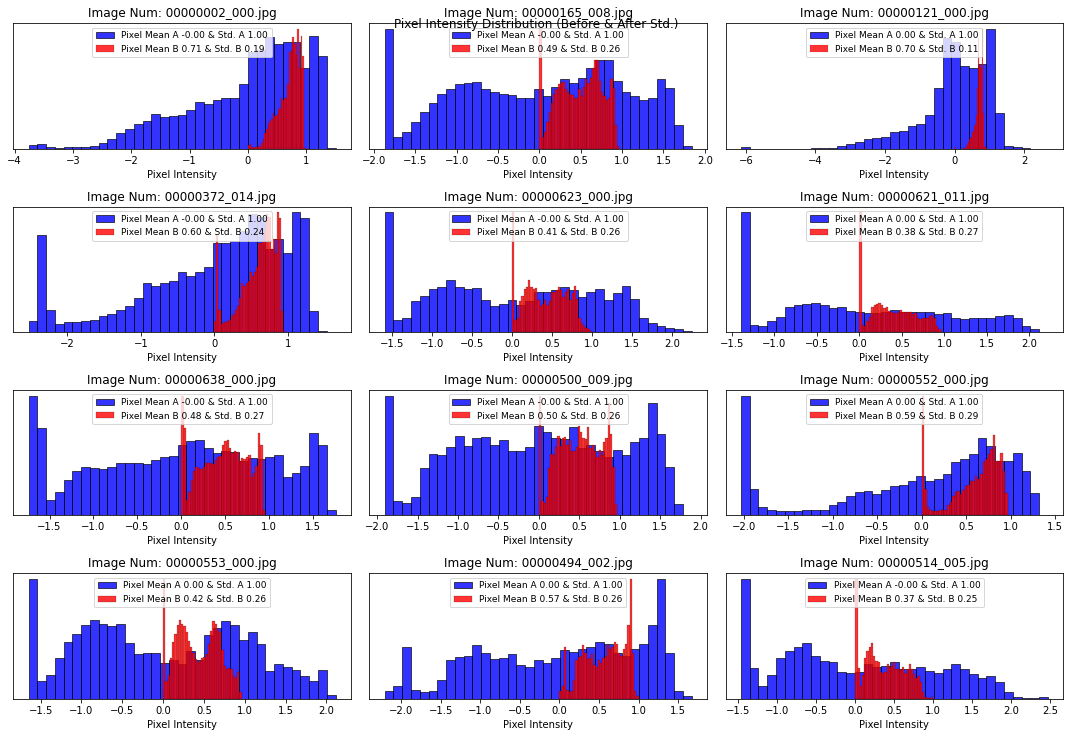

In [ ]:
fig = plt.figure(figsize=(15, 15))
count=1
for i, img in enumerate(train_im_n_selected):
    sample_one = os.path.join(root_train +labels[0]+'/', img)
    sample_img = Image.open(sample_one)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    sample_img_mean = np.mean(sample_img)
    sample_img_std = np.std(sample_img)
    new_sample_img = (sample_img - sample_img_mean)/sample_img_std
    ax = fig.add_subplot(int(npics/2) , 3, count, yticks=[])
    sns.histplot(new_sample_img.ravel(), 
             label=f'Pixel Mean A {np.mean(new_sample_img):.2f} & Std. A {np.std(new_sample_img):.2f}', kde=False, color='blue', bins=35, alpha=0.8)
    sns.histplot(sample_img.ravel(), 
             label=f'Pixel Mean B {np.mean(sample_img):.2f} & Std. B {np.std(sample_img):.2f}', kde=False, color='red', bins=35, alpha=0.8)
    plt.legend(loc='upper center', fontsize=9)
    plt.title('Image Num: %s'% (img))
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')
    count +=1
fig.suptitle('Pixel Intensity Distribution (Before & After Std.)')
plt.tight_layout()
plt.show()

In [ ]:
#### define a function that will be added as lambda layer later
def standardize_layer(tensor):
    tensor_mean = tf.math.reduce_mean(tensor)
    tensor_std = tf.math.reduce_std(tensor)
    new_tensor = (tensor-tensor_mean)/tensor_std
    return new_tensor

###ImageDataGenerator
Input_shape = (300, 300, 1)

Target_size = (300, 300)

batch_size = 32

In [ ]:
target_size = (300, 300)

input_shape = (300, 300, 1)

batch_size = 32


print("Training Dataset.....")
train_dir = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/train/', 
                                                                image_size=target_size, 
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                color_mode='grayscale',
                                                                label_mode='categorical',
                                                                validation_split=0.3,
                                                                subset='training',
                                                                seed = 1337)



print("Val Dataset....")
val_dir = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/train/', 
                                                              image_size=target_size, 
                                                              batch_size=batch_size,
                                                              color_mode='grayscale',
                                                              label_mode='categorical',
                                                              validation_split=0.3,
                                                              subset='validation',
                                                              seed = 1337)

print("Test Datast...")
test_dir = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/', 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               color_mode='grayscale',
                                                               label_mode='categorical')

Training Dataset.....
Found 3670 files belonging to 3 classes.
Using 2569 files for training.
Val Dataset....
Found 3670 files belonging to 3 classes.
Using 1101 files for validation.
Test Datast...
Found 761 files belonging to 3 classes.


Check the Number of Elements in Dataset (Train and Valid)

In [ ]:
num_elements = tf.data.experimental.cardinality(train_dir).numpy()
print (num_elements)
num_elements_val = tf.data.experimental.cardinality(val_dir).numpy()
print (num_elements_val)

81
35


Get the Class Names

In [ ]:
class_names = train_dir.class_names
print(class_names)

['covid', 'normal', 'pneumonia']


In [ ]:
new_train_ds = train_dir.concatenate(val_dir)

print (new_train_ds, train_dir)

train_size = int(0.8 * 116)
val_size = int(0.2 * 116)
    
train_ds = new_train_ds.take(train_size)
val_ds = new_train_ds.skip(train_size).take(val_size)


#### check the dataset size back again 
num_elements_train = tf.data.experimental.cardinality(train_ds).numpy()
print (num_elements_train)
num_elements_val_ds = tf.data.experimental.cardinality(val_ds).numpy()
print (num_elements_val_ds)

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
92
23


Define the Augmentation as Sequential and see images as examples

(32, 300, 300, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 3)


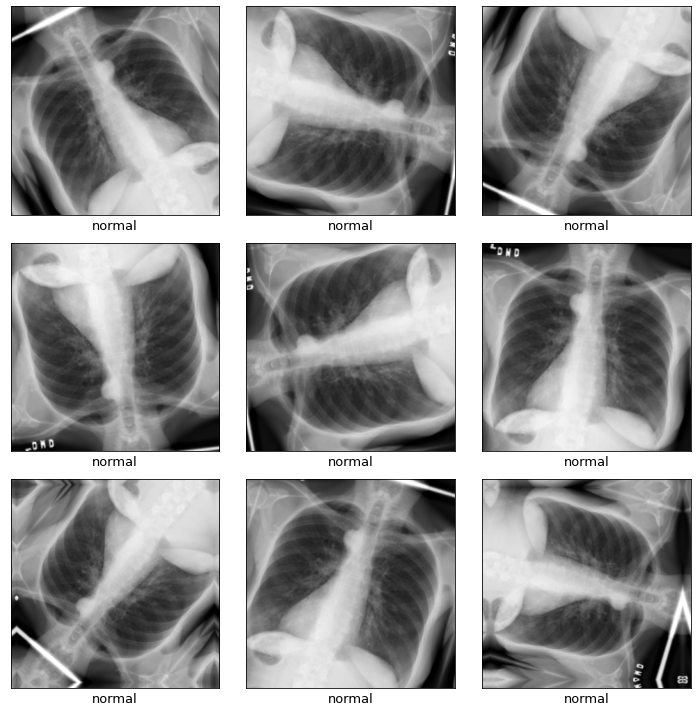

(32, 300, 300, 1) (300, 300, 1)


In [ ]:
from tensorflow.keras import layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(10), 
  layers.experimental.preprocessing.RandomZoom(0.1)
])



from itertools import islice, count

train_iter_35im, train_iter_35label = next(islice(train_ds, 35, None)) # access the 35th element (just a random check) from the iterator



print (train_iter_35im.shape, type(train_iter_35im))
print (train_iter_35label.shape)

# train_iter_5im = tf.expand_dims(train_iter_5im, 0)
train_iter_35label = train_iter_35label.numpy()


plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    aug_img = data_augmentation(train_iter_35im)
    plt.imshow(np.squeeze(aug_img[0]), cmap='gray')
    plt.xlabel(class_names[np.argmax(train_iter_35label)], fontsize=13)
plt.tight_layout()    
plt.show()

print (aug_img.shape, aug_img[0].shape)

In [ ]:
autotune = tf.data.AUTOTUNE ### most important function for speed up training


train_data_batches = train_ds.cache().prefetch(buffer_size=autotune)
valid_data_batches = val_ds.cache().prefetch(buffer_size=autotune)
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)
print(valid_data_batches)
print(test_data_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [ ]:
#### check the numbers again
print (train_data_batches, valid_data_batches)

num_elements_train_data_batches = tf.data.experimental.cardinality(train_data_batches).numpy()
print (num_elements_train_data_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))> <PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
92


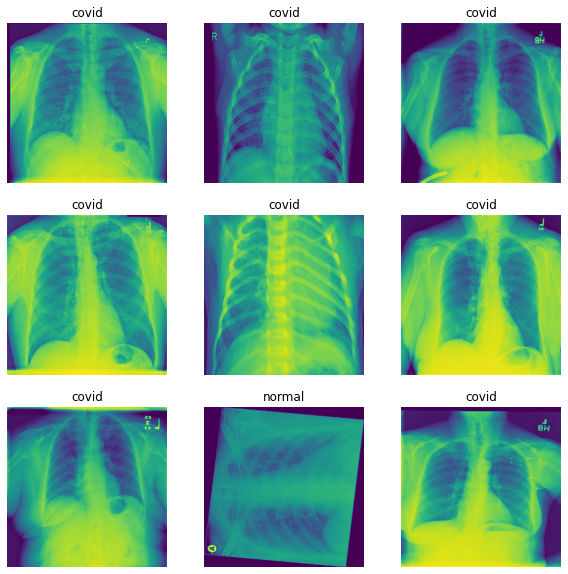

In [ ]:
### check if the data batches work properly or not 

plt.figure(figsize=(10, 10))
for images, labels in train_data_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        #plt.title(class_names[labels[i]])
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")

###Build Model as Sequential
Add the augmentation layer, pre-processing layers and custom lambda layer.

We will use pre-trained InceptionResNetV2 with imagenet

In [ ]:
## This cell was used to compile the baseline model


class customCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.epoch = epoch + 1
    if self.epoch % 2 == 0:
      print (
          'epoch num {}, train loss: {}, validation loss: {}'.format(epoch, logs['loss'], logs['val_loss']))

reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.2, patience=3, min_lr=1e-8, verbose=1)



## added after saving the best model  via val loss gives worse performance than the final step of the model 

mcp_save = ModelCheckpoint(filepath="best_model_weights_dense.h5",
                           save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')



##restore best weights added after 2nd training
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


### added after 2nd training 

METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

###Define model layers
We try two models on our data and compare them in the report.

#####Densenet121 Model

In [ ]:
input_shape = (300, 300, 3)

densenet121 = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape)

def build_model():
    inputs = Input((300, 300, 1))
    
    x = preprocess_input(inputs) # necessary as per keras documentation 
    x = layers.Lambda(rescale_layer)(x) # rescale incoming images
    x = layers.Lambda(standardize_layer)(x) # standardize incoming images
    x = layers.Lambda(data_augmentation)(x) # data augmentation layers
    x = Conv2D(3, (3,3), padding='same')(x) 
    # this is to fool the network that instead of rgb image we passed grayscale image but still have shape 3 at last axis (none, x, x, 3). 
    
    
    
    ###### Densenet121 + Some Top Layers
    x = BatchNormalization()(x)
    x = densenet121(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75)(x)

    x = Dense(256, activation=LeakyReLU())(x)
    x = Dropout(0.80)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(3, activation="sigmoid")(x)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='categorical_crossentropy', 
                 metrics=METRICS)



    
    return model

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 1)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 1)      0         
 a)                                                              
                                                                 
 lambda (Lambda)             (None, 300, 300, 1)       0         
                                                                 
 lambda_1 (Lambda)           (None, 300, 300, 1)       0         
                                                                 
 lambda_2 (Lambda)           (None, 300, 300, 1)       0     

Let's visualize our model

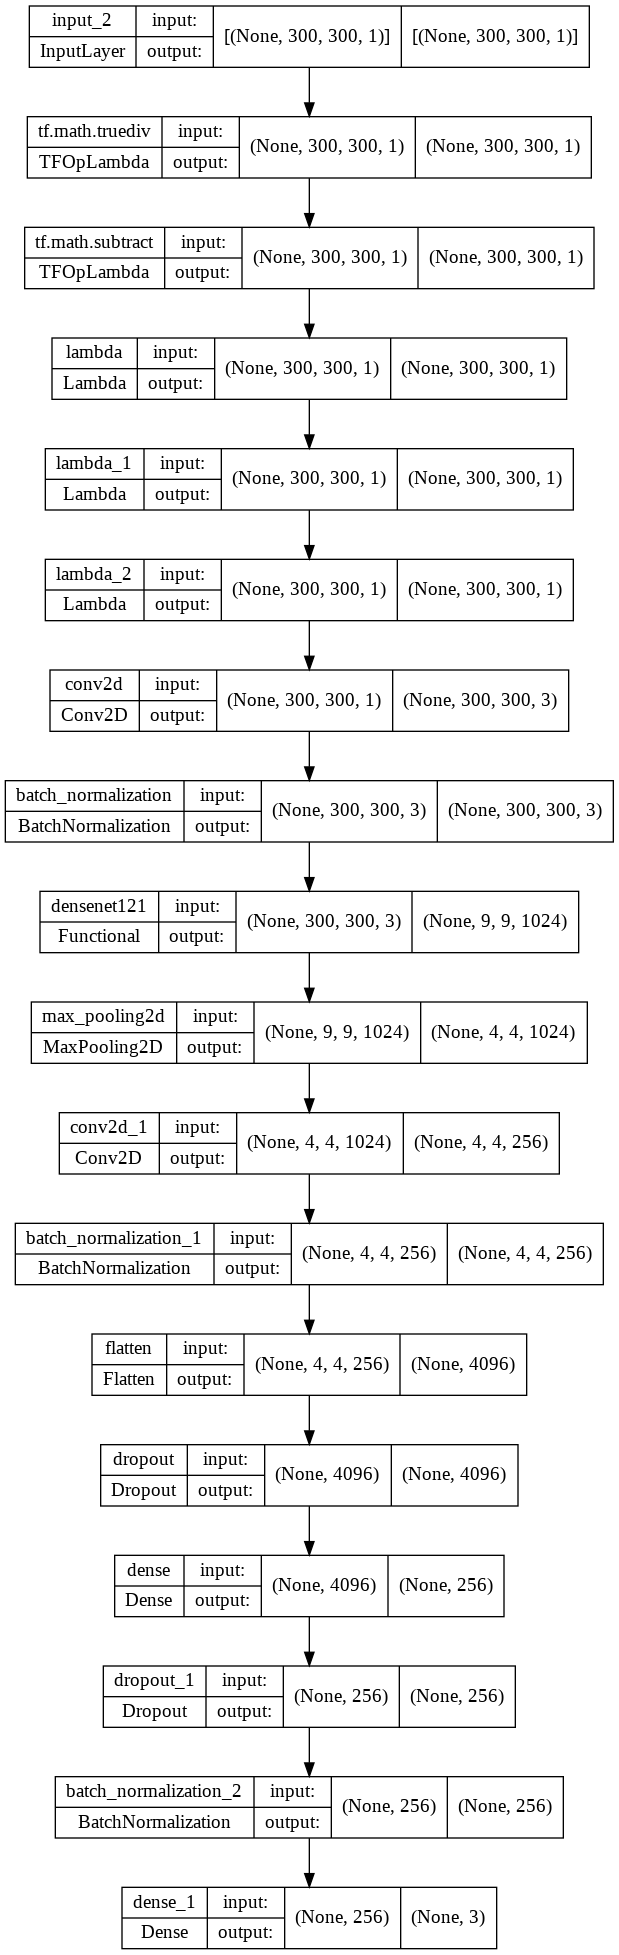

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

####Train the Network

In [ ]:
import time
start_time = time.time()
history = model.fit(train_data_batches, 
                    epochs=25, 
                    validation_data=valid_data_batches,callbacks=[mcp_save, es, reduce_lr])

end_time = time.time()

Epoch 1/25
92/92 [==============================] - 125s 999ms/step - loss: 1.0839 - accuracy: 0.5858 - precision: 0.4864 - recall: 0.7227 - prc: 0.5867 - val_loss: 11.7334 - val_accuracy: 0.3736 - val_precision: 0.4227 - val_recall: 0.7092 - val_prc: 0.4027 - lr: 0.0010
Epoch 2/25
92/92 [==============================] - 62s 677ms/step - loss: 0.6263 - accuracy: 0.7785 - precision: 0.6224 - recall: 0.8624 - prc: 0.8046 - val_loss: 1.5005 - val_accuracy: 0.6332 - val_precision: 0.5464 - val_recall: 0.7364 - val_prc: 0.7627 - lr: 0.0010
Epoch 3/25
92/92 [==============================] - 64s 698ms/step - loss: 0.4330 - accuracy: 0.8490 - precision: 0.6754 - recall: 0.9134 - prc: 0.8835 - val_loss: 0.6866 - val_accuracy: 0.7840 - val_precision: 0.5888 - val_recall: 0.8736 - val_prc: 0.8595 - lr: 0.0010
Epoch 4/25
92/92 [==============================] - 65s 702ms/step - loss: 0.3536 - accuracy: 0.8781 - precision: 0.7040 - recall: 0.9281 - prc: 0.9137 - val_loss: 0.4848 - val_accuracy: 0

In [ ]:
print ('total time taken: in Minutes', (end_time-start_time)/60.)

total time taken: in Minutes 31.142408088843027


#####Loss and Accuracy for Train and Validation

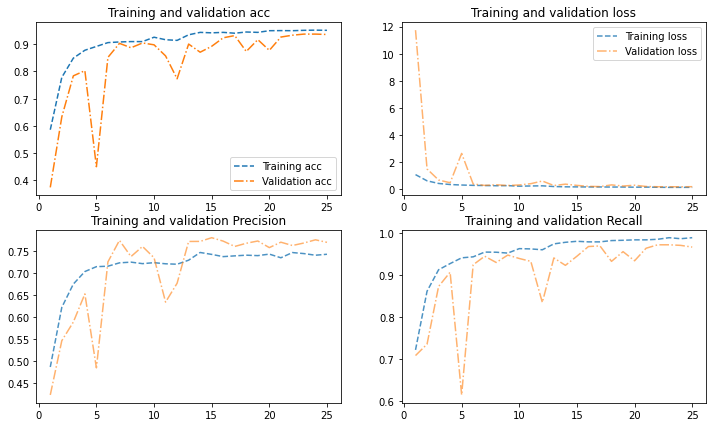

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']


epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(12, 7))
fig.add_subplot(221)

plt.plot(epochs, acc, linestyle='--', label = "Training acc")
plt.plot(epochs, val_acc, linestyle='-.', label = "Validation acc")
plt.title("Training and validation acc")
plt.legend()

fig.add_subplot(222)
plt.plot(epochs, loss, linestyle='--', label = "Training loss", alpha=0.8)
plt.plot(epochs, val_loss, linestyle='-.', label = "Validation loss", alpha=0.6)
plt.title("Training and validation loss")
plt.legend()

fig.add_subplot(223)
plt.plot(epochs, precision, linestyle='--', label = "Training Precision", alpha=0.8)
plt.plot(epochs, val_precision, linestyle='-.', label = "Validation Precision", alpha=0.6)
plt.title("Training and validation Precision")

fig.add_subplot(224)
plt.plot(epochs, recall, linestyle='--', label = "Training Recall", alpha=0.8)
plt.plot(epochs, val_recall, linestyle='-.', label = "Validation Recall", alpha=0.6)
plt.title("Training and validation Recall")

plt.show()

In [ ]:
test_dir = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/', 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               color_mode='grayscale',
                                                               label_mode='categorical',
                                                               seed=1337)

Found 761 files belonging to 3 classes.


In [ ]:
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)

densenet121 evaluation

In [ ]:
model.evaluate(test_data_batches)

24/24 [==============================] - 14s 463ms/step - loss: 0.1731 - accuracy: 0.9514 - precision: 0.7607 - recall: 0.9816 - prc: 0.9758


[0.17306940257549286,
 0.9513797760009766,
 0.7606924772262573,
 0.9816031455993652,
 0.975800633430481]

####Prediction and Confusion Matrix

In [ ]:
y_pred = model.predict(test_data_batches)
print ('check y_pred: ', y_pred[0:10])

check y_pred:  [[0.99972814 0.04484919 0.03308145]
 [0.98911285 0.30687153 0.02950339]
 [0.96953815 0.13256052 0.14202906]
 [0.9995727  0.07382715 0.01186535]
 [0.07262039 0.8991526  0.61838883]
 [0.10524937 0.9755204  0.44346187]
 [0.00417226 0.18060909 0.99586785]
 [0.12380294 0.04322939 0.98600465]
 [0.0156157  0.1141508  0.9930442 ]
 [0.9781407  0.12955473 0.12115131]]


In [ ]:
#### set a different threshold 

y_pred_th = (y_pred > 0.75).astype(np.float32)

print (y_pred_th[0:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [ ]:
true_categories = tf.concat([y for x, y in test_data_batches], axis=0)
print ('check true catagories: ', true_categories[0:10])

check true catagories:  tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]], shape=(10, 3), dtype=float32)


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.asarray(true_categories).argmax(axis=1),np.asarray(y_pred_th).argmax(axis=1))

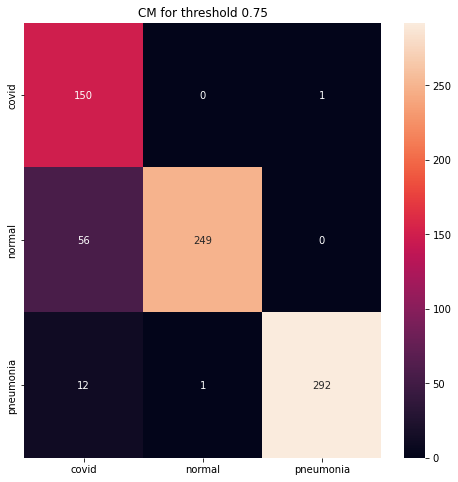

In [ ]:
plt.figure(figsize=(8,8))
plt.title('CM for threshold 0.75')
sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_names[i] for i in range(len(class_names))], 
                      yticklabels = [class_names[i] for i in range(len(class_names))], fmt="d")
fig = sns_hmp.get_figure()

st Set Predictions and Images with Densenet121 model

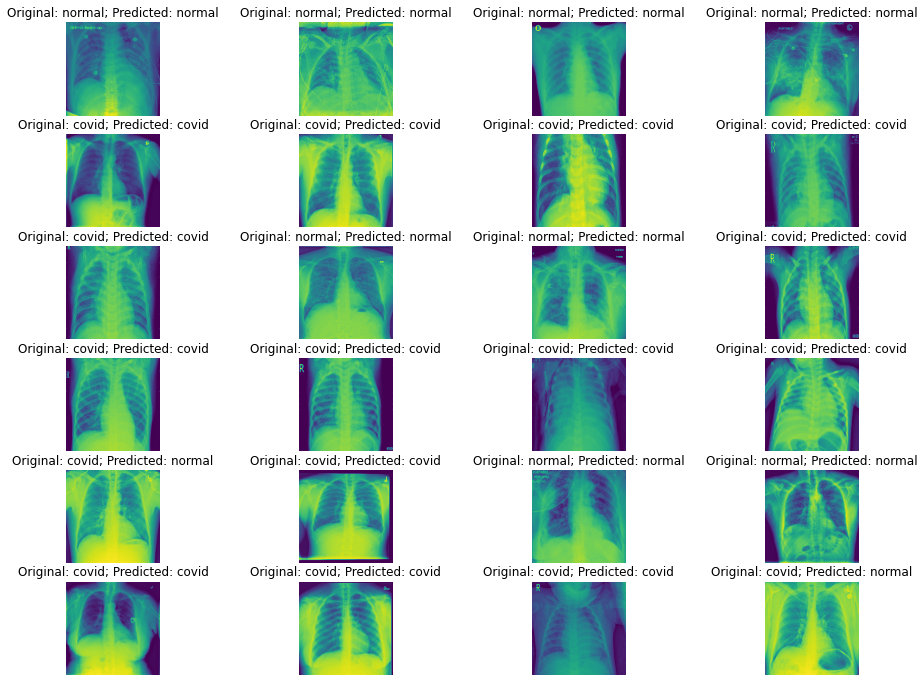

In [ ]:
plt.figure(figsize=(16, 12))
for images, labels in test_data_batches.take(1):
    for i in range(24):
        ax = plt.subplot(6, 4, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        #plt.title(class_names[labels[i]])
        
        y_pred_batch = model.predict(tf.expand_dims(images[i], axis=0, ))
        y_pred_75th = (y_pred_batch > 0.75).astype(np.uint8)
        original_label = class_names[labels[i].numpy().astype("uint8")[0]]
        predicted_label = class_names[y_pred_75th[0].astype("uint8")[0]]
        plt.title(f'Original: {original_label}; Predicted: {predicted_label}')
        plt.axis("off") 

Test an images from test folder

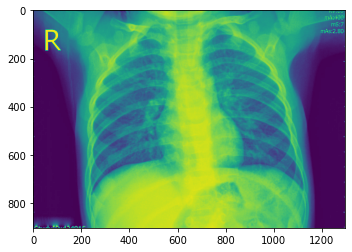

In [ ]:
img_path = "/content/drive/My Drive/Colab Notebooks/COVID19_Dataset/test/pneumonia/person1353_bacteria_3446.jpg"
img=plt.imread(img_path)
plt.imshow(img)
plt.show()

Doing preprocessing

In [ ]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
img = image.load_img(img_path, target_size=(300, 300))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
print(img_preprocessed.shape)

(1, 300, 300, 3)


In [ ]:
prediction = model.predict(img_preprocessed)

In [ ]:
print(prediction)

[[0.13806698 0.05539061 0.9813896 ]]


In [ ]:
pred = class_names[np.argmax(prediction)]
pred

'pneumonia'

In [ ]:
print(class_names)

['covid', 'normal', 'pneumonia']
